In [14]:
import os
import torch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split

from sklearn.preprocessing import OneHotEncoder

from transformers import AutoTokenizer, AutoModel

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1")
model = AutoModel.from_pretrained("dmis-lab/biobert-base-cased-v1.1")

In [3]:
df = pd.read_csv(f'{os.getcwd()}/data/mean_tpm.csv', index_col=0)

In [4]:
# Function to uniformly sample from each group
def uniform_sample(df, group_cols, n_samples_per_group=1):
    # Group by the specified columns
    grouped = df.groupby(group_cols)
    
    # Uniformly sample n_samples_per_group from each group
    sampled_df = grouped.apply(lambda x: x.sample(n=min(len(x), n_samples_per_group)))
    
    # Reset index to flatten the DataFrame
    sampled_df = sampled_df.reset_index(drop=True)
    
    return sampled_df

# Columns to group by
group_cols = ['species']

# Number of samples to take from each group
n_samples_per_group = 2

# Get the uniformly sampled DataFrame
sampled_df = uniform_sample(df, group_cols, n_samples_per_group)

In [5]:
sequences = sampled_df['upstream200'].tolist()
tokens = tokenizer(sequences, padding=True, truncation=True, return_tensors='pt')

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [6]:
with torch.no_grad():
    embeddings = model(**tokens).last_hidden_state

In [7]:
len(sampled_df), embeddings.shape

(4510, torch.Size([4510, 46, 768]))

In [8]:
enc_species = OneHotEncoder()
encoded_species = enc_species.fit_transform(sampled_df[['species']]).toarray()

enc_stress = OneHotEncoder()
encoded_stress_condition = enc_stress.fit_transform(sampled_df[['stress_condition']]).toarray()

species_tensor = torch.tensor(encoded_species, dtype=torch.long)
stress_tensor = torch.tensor(encoded_stress_condition, dtype=torch.long)

In [9]:
y_log = np.log1p(sampled_df['mean_tpm'].values)
# scaler = StandardScaler()
# y_scaled = scaler.fit_transform(y_log.reshape(-1, 1)).flatten()
# TODO: Convert y_scaled to tensor
y_tensor = torch.tensor(y_log, dtype=torch.float32).unsqueeze(1)

In [10]:
embedding_tensor = embeddings.mean(dim=1)

dataset = TensorDataset(embedding_tensor, species_tensor, stress_tensor, y_tensor)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 1024 * 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
class DNA_CNN(nn.Module):
    def __init__(self, num_species, num_stress_conditions, embedding_dim=768):
        super(DNA_CNN, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 128)
        self.fc_species = nn.Linear(num_species, 8)
        self.fc_stress = nn.Linear(num_stress_conditions, 8)
        self.fc2 = nn.Linear(128 + 8 + 8, 1)

    def forward(self, embeddings, species, stress):
        x = torch.relu(self.fc1(embeddings))
        species = torch.relu(self.fc_species(species))
        stress = torch.relu(self.fc_stress(stress))
        x = torch.cat((x, species, stress), dim=1)
        x = self.fc2(x)
        return x

In [12]:
class EnhancedDNA_CNN(nn.Module):
    def __init__(self, num_species, num_stress_conditions, embedding_dim=768):
        super(EnhancedDNA_CNN, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        
        # Embedding layers for species and stress conditions
        self.species_embedding = nn.Embedding(num_species, 16)
        self.stress_embedding = nn.Embedding(num_stress_conditions, 16)
        
        # Ensure the concatenated dimension matches the input of the next layer
        self.fc3 = nn.Linear(128 + 16 + 16, 64)
        self.fc4 = nn.Linear(64, 1)
        
        # Pooling layers to reduce dimensionality
        self.species_pool = nn.AdaptiveAvgPool1d(1)
        self.stress_pool = nn.AdaptiveAvgPool1d(1)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, embeddings, species, stress):
        x = F.relu(self.fc1(embeddings))
        x = F.relu(self.fc2(x))
        
        # Obtain embeddings for species and stress conditions
        species_embed = F.relu(self.species_embedding(species))  # Shape: (batch_size, sequence_length, 16)
        stress_embed = F.relu(self.stress_embedding(stress))     # Shape: (batch_size, sequence_length, 16)
        
        # Apply pooling to reduce the dimensionality
        species_embed = self.species_pool(species_embed.permute(0, 2, 1)).squeeze(2)  # Shape: (batch_size, 16)
        stress_embed = self.stress_pool(stress_embed.permute(0, 2, 1)).squeeze(2)     # Shape: (batch_size, 16)
        
        # Concatenate all the embeddings
        x = torch.cat((x, species_embed, stress_embed), dim=1)  # Shape: (batch_size, 128 + 16 + 16)
        
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        return x

In [22]:
num_species = encoded_species.shape[1]
num_stress_conditions = encoded_stress_condition.shape[1]
model = EnhancedDNA_CNN(num_species, num_stress_conditions).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_losses = []
val_losses = []

num_epochs = 30  
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for step, (embeddings, species, stress, targets) in enumerate(train_loader):
        embeddings, species, stress, targets = embeddings.to(device), species.to(device), stress.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(embeddings, species, stress)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        step_loss = loss.item() * embeddings.size(0)
        train_loss += step_loss

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for embeddings, species, stress, targets in val_loader:
            embeddings, species, stress, targets = embeddings.to(device), species.to(device), stress.to(device), targets.to(device)
            outputs = model(embeddings, species, stress)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * embeddings.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

loss_df = pd.DataFrame({'epoch': range(1, num_epochs + 1), 'train_loss': train_losses, 'val_loss': val_losses})

model.eval()
test_loss = 0.0
predictions, ground_truth = [], []
with torch.no_grad():
    for embeddings, species, stress, targets in test_loader:
        embeddings, species, stress, targets = embeddings.to(device), species.to(device), stress.to(device), targets.to(device)
        outputs = model(embeddings, species, stress)
        predictions.append(outputs.cpu())
        ground_truth.append(targets.cpu())
        loss = criterion(outputs, targets)
        test_loss += loss.item() * embeddings.size(0)

test_loss /= len(test_loader.dataset)
print(f'Test Loss: {test_loss:.4f}')

predictions = torch.cat(predictions, axis=0)
ground_truth = torch.cat(ground_truth, axis=0)
output_df = pd.DataFrame({'actual': ground_truth.flatten(), 'predicted': predictions.flatten()})

Epoch [1/30], Train Loss: 28.4634
Epoch [1/30], Validation Loss: 28.5520
Epoch [2/30], Train Loss: 28.2906
Epoch [2/30], Validation Loss: 28.4112
Epoch [3/30], Train Loss: 28.1803
Epoch [3/30], Validation Loss: 28.2729
Epoch [4/30], Train Loss: 28.0263
Epoch [4/30], Validation Loss: 28.1606
Epoch [5/30], Train Loss: 27.9151
Epoch [5/30], Validation Loss: 28.0574
Epoch [6/30], Train Loss: 27.8140
Epoch [6/30], Validation Loss: 27.9548
Epoch [7/30], Train Loss: 27.7270
Epoch [7/30], Validation Loss: 27.8517
Epoch [8/30], Train Loss: 27.6179
Epoch [8/30], Validation Loss: 27.7476
Epoch [9/30], Train Loss: 27.4964
Epoch [9/30], Validation Loss: 27.6444
Epoch [10/30], Train Loss: 27.4088
Epoch [10/30], Validation Loss: 27.5419
Epoch [11/30], Train Loss: 27.2925
Epoch [11/30], Validation Loss: 27.4465
Epoch [12/30], Train Loss: 27.2009
Epoch [12/30], Validation Loss: 27.3509
Epoch [13/30], Train Loss: 27.0981
Epoch [13/30], Validation Loss: 27.2532
Epoch [14/30], Train Loss: 27.0151
Epoch [1

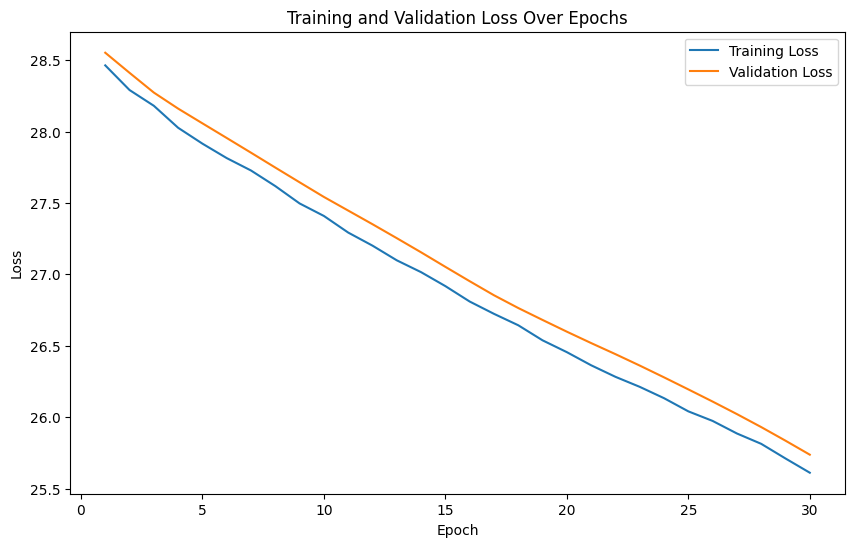

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(loss_df['epoch'], loss_df['train_loss'], label='Training Loss')
plt.plot(loss_df['epoch'], loss_df['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [24]:
predictions

tensor([[0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0.1806],
        [0

In [25]:
ground_truth

tensor([[4.9110],
        [7.0388],
        [3.9224],
        [5.5318],
        [3.5918],
        [4.2926],
        [5.6535],
        [5.8471],
        [5.8971],
        [3.7690],
        [4.8558],
        [4.9808],
        [6.9474],
        [4.6166],
        [5.1306],
        [4.4544],
        [4.9000],
        [2.8727],
        [5.1208],
        [5.4259],
        [5.6406],
        [4.9225],
        [8.0941],
        [4.6892],
        [5.6411],
        [4.8481],
        [5.0774],
        [5.4700],
        [6.2917],
        [3.8014],
        [6.2325],
        [4.3503],
        [4.8093],
        [5.0092],
        [4.6220],
        [6.1875],
        [5.1428],
        [5.8706],
        [7.1353],
        [7.7506],
        [2.5897],
        [3.6202],
        [4.2601],
        [4.2764],
        [4.1845],
        [6.6522],
        [5.6405],
        [5.3616],
        [3.7617],
        [2.3014],
        [4.0030],
        [3.3700],
        [5.1670],
        [3.9868],
        [5.5233],
        [3

In [19]:
predictions.mean(), ground_truth.mean()

(tensor(0.1476), tensor(4.8752))

In [20]:
predictions.max(), ground_truth.max()

(tensor(0.1476), tensor(8.9038))

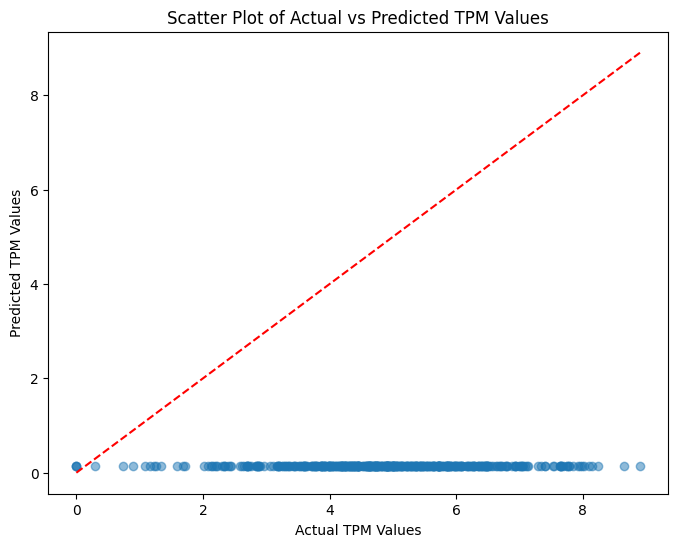

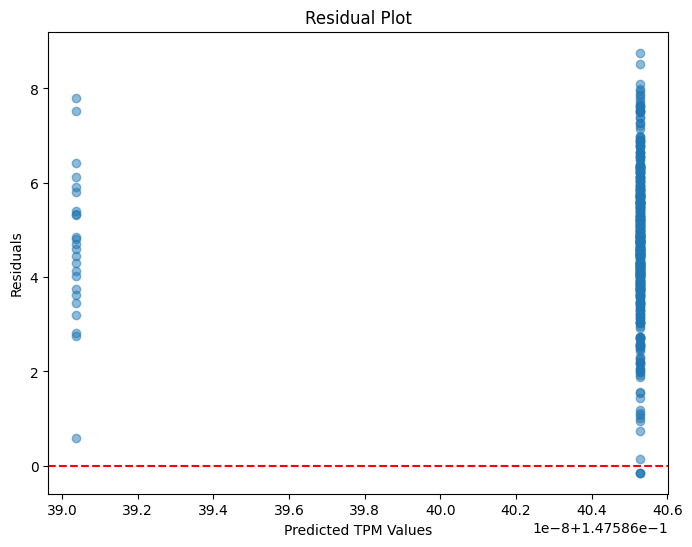

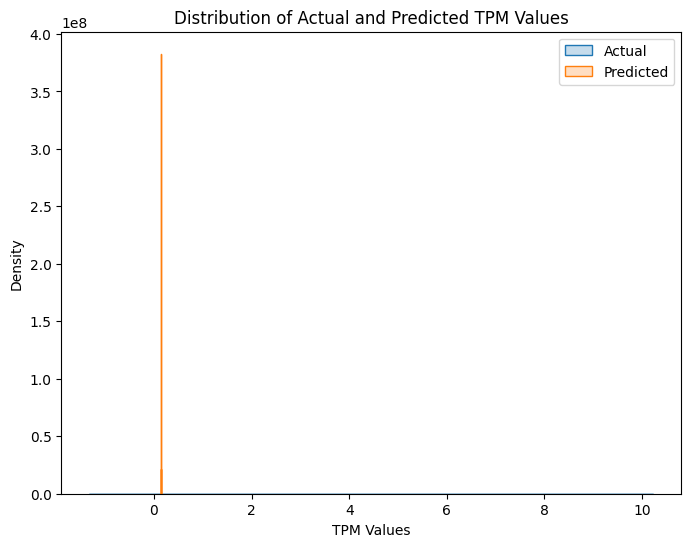

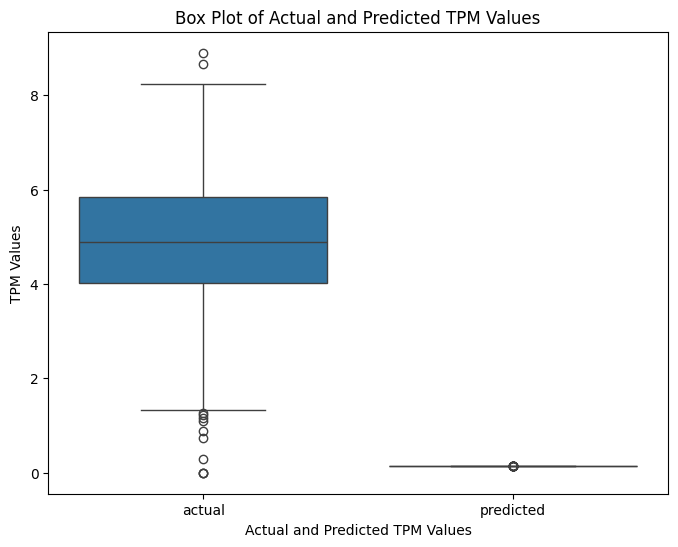

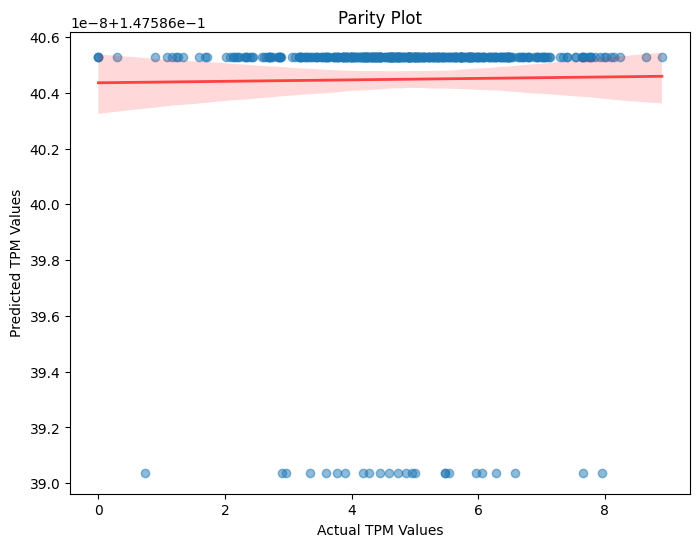

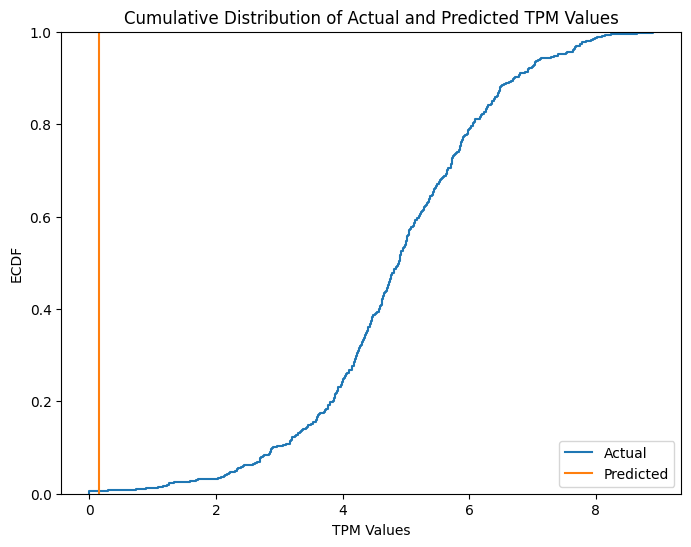

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `output_df` is already defined and contains 'actual' and 'predicted' columns

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(output_df['actual'], output_df['predicted'], alpha=0.5)
plt.plot([output_df['actual'].min(), output_df['actual'].max()], [output_df['actual'].min(), output_df['actual'].max()], 'r--')
plt.xlabel('Actual TPM Values')
plt.ylabel('Predicted TPM Values')
plt.title('Scatter Plot of Actual vs Predicted TPM Values')
plt.show()

# Residual Plot
output_df['residuals'] = output_df['actual'] - output_df['predicted']
plt.figure(figsize=(8, 6))
plt.scatter(output_df['predicted'], output_df['residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted TPM Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Distribution Plot
plt.figure(figsize=(8, 6))
sns.kdeplot(output_df['actual'], label='Actual', fill=True)
sns.kdeplot(output_df['predicted'], label='Predicted', fill=True)
plt.xlabel('TPM Values')
plt.ylabel('Density')
plt.title('Distribution of Actual and Predicted TPM Values')
plt.legend()
plt.show()

# Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=output_df[['actual', 'predicted']])
plt.xlabel('Actual and Predicted TPM Values')
plt.ylabel('TPM Values')
plt.title('Box Plot of Actual and Predicted TPM Values')
plt.show()

# Parity Plot
plt.figure(figsize=(8, 6))
sns.regplot(x='actual', y='predicted', data=output_df, scatter_kws={'alpha':0.5}, line_kws={"color":"r","alpha":0.7,"lw":2})
plt.xlabel('Actual TPM Values')
plt.ylabel('Predicted TPM Values')
plt.title('Parity Plot')
plt.show()

# Cumulative Distribution Function (CDF) Plot
plt.figure(figsize=(8, 6))
sns.ecdfplot(output_df['actual'], label='Actual')
sns.ecdfplot(output_df['predicted'], label='Predicted')
plt.xlabel('TPM Values')
plt.ylabel('ECDF')
plt.title('Cumulative Distribution of Actual and Predicted TPM Values')
plt.legend()
plt.show()
